In [1]:
%load_ext autoreload
%autoreload 2
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:96% !important; }</style>"))

import os
import torch
import matplotlib.pyplot as plt
from skimage.io import imread
import numpy as np
# Util function for loading meshes
from pytorch3d.io import load_objs_as_meshes
%matplotlib notebook
# Data structures and functions for rendering
from pytorch3d.structures import Meshes, Textures
from pytorch3d.renderer import (
    look_at_view_transform,
    OpenGLPerspectiveCameras, 
    PointLights, 
    DirectionalLights, 
    Materials, 
    RasterizationSettings, 
    MeshRenderer, 
    MeshRasterizer,  
    TexturedSoftPhongShader,
    SfMPerspectiveCameras,
)

# add path for demo utils functions 
import sys
import os
sys.path.append(os.path.abspath(''))

In [2]:
from utils import image_grid

In [3]:
# Setup
device = torch.device("cuda:0")
torch.cuda.set_device(device)

# Set paths
DATA_DIR = "./3_input"
obj_filename = os.path.join(DATA_DIR, "cow_mesh/cow.obj")

# Load obj file
mesh = load_objs_as_meshes([obj_filename], device=device)
texture_image=mesh.textures.maps_padded()
vs = mesh.verts_packed().cpu().numpy()
print(len(vs))
print(vs.shape)

2930
(2930, 3)


In [4]:
plt.figure(figsize=(7,7))
plt.imshow(texture_image[0].squeeze().cpu().numpy())
plt.grid("off");
plt.axis('off');

<IPython.core.display.Javascript object>

In [5]:
# Initialize an OpenGL perspective camera.
# With world coordinates +Y up, +X left and +Z in, the front of the cow is facing the -Z direction. 
# So we move the camera by 180 in the azimuth direction so it is facing the front of the cow. 

# gives extrinsics T
# gives extrinsics R
R1, T1 = look_at_view_transform(3, 0, 90) 
R2, T2 = look_at_view_transform(3, 0, 0)
R3, T3 = look_at_view_transform(3, 0, 30)

R = torch.cat([R1, R2, R3])
T = torch.cat([T1, T2, T3])
print(R.shape)
print(T.shape)
# R = R1
# T = T1
cameras = OpenGLPerspectiveCameras(device=device, R=R, T=T)

cx = 0.0
cy = 0.0
fx = 1.0
fy = 1.0
principal_point = np.array([cx, cy]).astype(np.float32)
principal_point = torch.from_numpy(principal_point).unsqueeze(0)
focal_length = np.array([fx, fy]).astype(np.float32)
focal_length = torch.from_numpy(focal_length).unsqueeze(0)

# cameras = SfMPerspectiveCameras(device=device, R=R, T=T, focal_length=focal_length, principal_point=principal_point)
camR = cameras.R
camT = cameras.T

print(camR)
print(camT)

torch.Size([3, 3, 3])
torch.Size([3, 3])
tensor([[[ 4.3711e-08,  0.0000e+00, -1.0000e+00],
         [-0.0000e+00,  1.0000e+00,  0.0000e+00],
         [ 1.0000e+00,  0.0000e+00,  4.3711e-08]],

        [[-1.0000e+00,  0.0000e+00,  0.0000e+00],
         [ 0.0000e+00,  1.0000e+00,  0.0000e+00],
         [ 0.0000e+00,  0.0000e+00, -1.0000e+00]],

        [[-8.6603e-01,  0.0000e+00, -5.0000e-01],
         [ 0.0000e+00,  1.0000e+00,  0.0000e+00],
         [ 5.0000e-01,  0.0000e+00, -8.6603e-01]]], device='cuda:0')
tensor([[-0.0000, -0.0000, 3.0000],
        [-0.0000, -0.0000, 3.0000],
        [-0.0000, -0.0000, 3.0000]], device='cuda:0')


In [6]:
from mpl_toolkits.mplot3d import Axes3D  # noqa: F401 unused import
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(5, 5))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(vs[:,0], vs[:,1], vs[:,2], s=0.1)
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
L = 3
ax.set_xlim([-L, L])
ax.set_ylim([-L, L])
ax.set_zlim([-L, L])
L = 2
ax.plot([0, L], [0, 0], [0, 0], c='r')
ax.plot([0, 0], [0, L], [0, 0], c='g')
ax.plot([0, 0], [0, 0], [0, L], c='b')

cam_positions = cameras.get_camera_center().squeeze().cpu().numpy()
for cam_idx in range(T.shape[0]):
    # camera
    t = T[cam_idx].squeeze().cpu().numpy()
    r = R[cam_idx].squeeze().cpu().numpy()

    # to pose
    t = -r.T.dot(t)
    # t = -r.dot(t)
    r = r.T

    ax.scatter(t[0], t[1], t[2], c='r', s=10)
    cam_pos = cam_positions[cam_idx]
    ax.scatter(cam_pos[0], cam_pos[1], cam_pos[2], c='b', marker='x', s=10)
    
    Xc_axis = t + r.dot(np.float32([L, 0, 0]))
    Yc_axis = t + r.dot(np.float32([0, L, 0]))
    Zc_axis = t + r.dot(np.float32([0, 0, L]))
    ax.plot([t[0], Xc_axis[0]], [t[1], Xc_axis[1]], [t[2], Xc_axis[2]], c='r', linestyle=':')
    ax.plot([t[0], Yc_axis[0]], [t[1], Yc_axis[1]], [t[2], Yc_axis[2]], c='g', linestyle=':')
    ax.plot([t[0], Zc_axis[0]], [t[1], Zc_axis[1]], [t[2], Zc_axis[2]], c='b', linestyle=':')
plt.show()


<IPython.core.display.Javascript object>

In [17]:
# Define the settings for rasterization and shading. Here we set the output image to be of size
# 512x512. As we are rendering images for visualization purposes only we will set faces_per_pixel=1
# and blur_radius=0.0. We also set bin_size and max_faces_per_bin to None which ensure that 
# the faster coarse-to-fine rasterization method is used. Refer to rasterize_meshes.py for 
# explanations of these parameters. Refer to docs/notes/renderer.md for an explanation of 
# the difference between naive and coarse-to-fine rasterization. 
raster_settings = RasterizationSettings(
    image_size=512, 
    blur_radius=0.0, 
    faces_per_pixel=1, 
    bin_size = None,  # this setting controls whether naive or coarse-to-fine rasterization is used
    max_faces_per_bin = None  # this setting is for coarse rasterization
)

# Place a point light in front of the object. As mentioned above, the front of the cow is facing the 
# -z direction. 
light_pos = torch.from_numpy(np.float32([[0, 2, 0], [2, 0, 0], [0, 0, 2]])).to(device)
# ambient_color = torch.from_numpy(np.ones(light_pos.shape).astype(np.float32)*0.2)
# diffuse_color = torch.from_numpy(np.ones(light_pos.shape).astype(np.float32)*0.3)
lights = PointLights(device=device, location=light_pos)
lights.location = light_pos
# Create a phong renderer by composing a rasterizer and a shader. The textured phong shader will 
# interpolate the texture uv coordinates for each vertex, sample from a texture image and 
# apply the Phong lighting model
renderer = MeshRenderer(
    rasterizer=MeshRasterizer(
        cameras=cameras, 
        raster_settings=raster_settings
    ),
    shader=TexturedSoftPhongShader(
        device=device, 
        cameras=cameras,
        lights=lights
    )
)

3
composed_matrix: torch.Size([3, 4, 4])
points_batch: torch.Size([3, 2930, 4])
composed_matrix: torch.Size([3, 4, 4])
points_batch: torch.Size([3, 2930, 4])


<IPython.core.display.Javascript object>


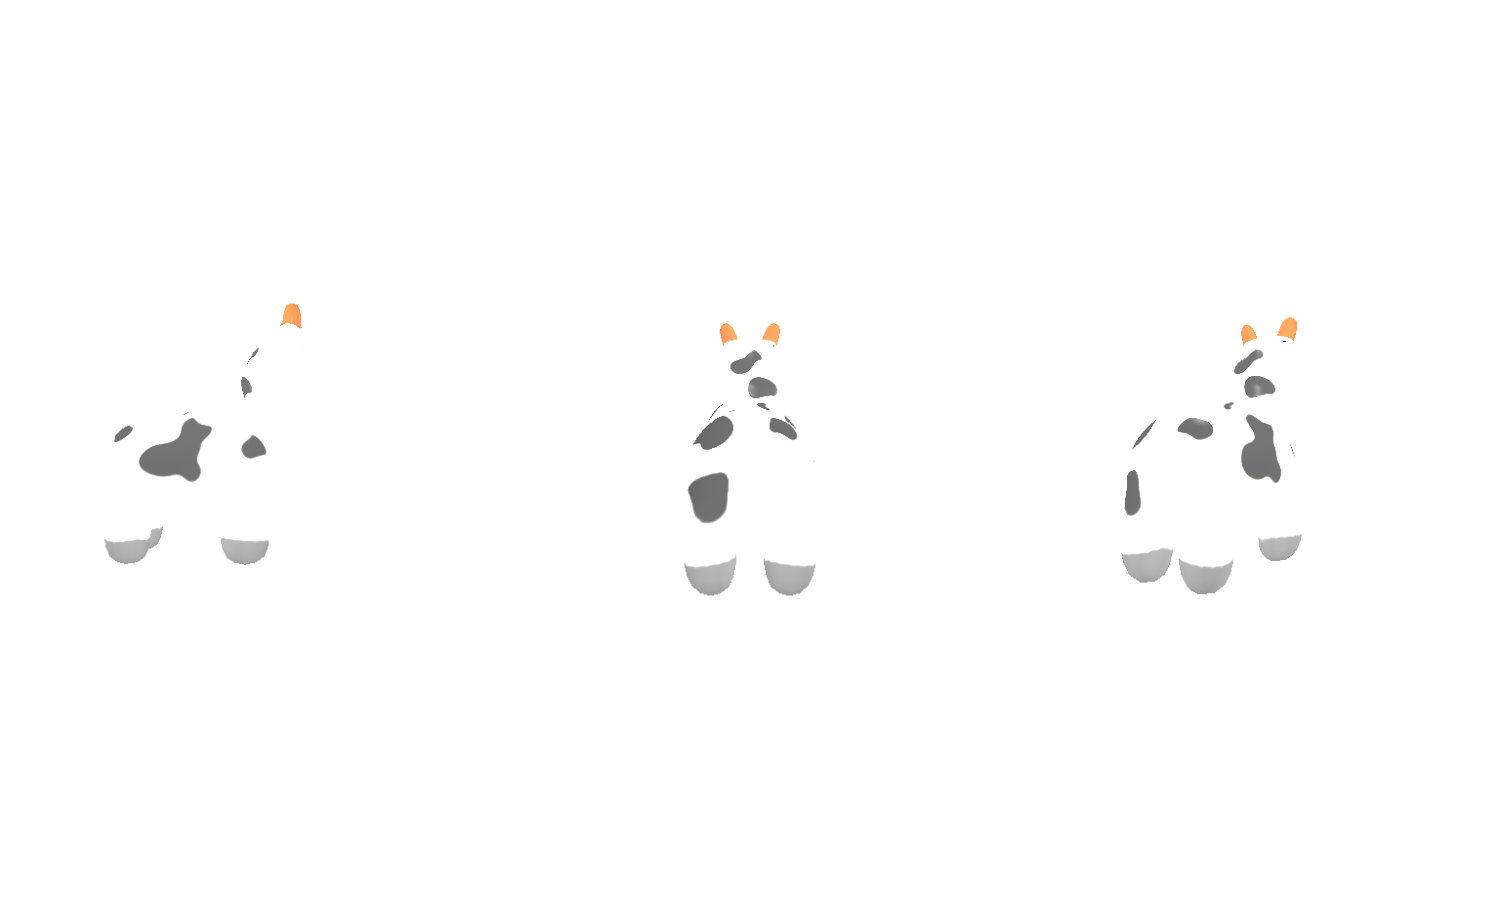

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


In [18]:
batch_size = 3
meshes = mesh.extend(batch_size)
print(len(cameras))
images = renderer(meshes, cameras=cameras, lights=lights)
image_grid(images.cpu().numpy(), rows=1, cols=3, rgb=True)

# Batches - Pytorch example

In [ ]:
# Set batch size - this is the number of different viewpoints from which we want to render the mesh.
batch_size = 20

# Create a batch of meshes by repeating the cow mesh and associated textures. 
# Meshes has a useful `extend` method which allows us do this very easily. 
# This also extends the textures. 
meshes = mesh.extend(batch_size)

# Get a batch of viewing angles. 
elev = torch.linspace(0, 180, batch_size)
azim = torch.linspace(-180, 180, batch_size)

# All the cameras helper methods support mixed type inputs and broadcasting. So we can 
# view the camera from the same distance and specify dist=2.7 as a float,
# and then specify elevation and azimuth angles for each viewpoint as tensors. 
R, T = look_at_view_transform(dist=2.7, elev=elev, azim=azim)
print(R.shape)
cameras = OpenGLPerspectiveCameras(device=device, R=R, T=T)
print(len(cameras))
# Move the light back in front of the cow which is facing the -z direction.
lights = PointLights(device=device, location=[[0.0, 0.0, -3.0]])
lights.location = torch.tensor([[0.0, 0.0, -3.0], [0.0, 1.0, -3.0], [0.0, 1.0, -3.0]], device=device)
print(lights.location.shape)
raster_settings = RasterizationSettings(
    image_size=64, 
    blur_radius=0.0, 
    faces_per_pixel=1, 
    bin_size = None,  # this setting controls whether naive or coarse-to-fine rasterization is used
    max_faces_per_bin = None  # this setting is for coarse rasterization
)
renderer = MeshRenderer(
    rasterizer=MeshRasterizer(
        cameras=cameras, 
        raster_settings=raster_settings
    ),
    shader=TexturedSoftPhongShader(
        device=device, 
        cameras=cameras,
        lights=lights
    )
)

In [ ]:
images = renderer(meshes, cameras=cameras, lights=lights)
image_grid(images.cpu().numpy(), rows=4, cols=5, rgb=True)